## Imports

In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 57.5 MB/s eta 0:00:00:00:0100:01


In [2]:
import os
import random
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.measure import label, regionprops

sns.set(style="whitegrid")

# Loading data
The dataset used for this training is from [CAS Landslide](https://www.nature.com/articles/s41597-023-02847-z). It is a set of:
 - train images + segmentation masks
 - validation images + segmentation masks
 - test images + segmentation masks

In [4]:
# Dataset paths
DATA_DIR = "/kaggle/input/cas-landslide-dataset-satellite/CAS_Landslide_Dataset_Satellite"
x_train_dir = os.path.join(DATA_DIR, "train", "img")
y_train_dir = os.path.join(DATA_DIR, "train", "mask")

x_valid_dir = os.path.join(DATA_DIR, "val", "img")
y_valid_dir = os.path.join(DATA_DIR, "val", "mask")

x_test_dir = os.path.join(DATA_DIR, "test", "img")
y_test_dir = os.path.join(DATA_DIR, "test", "mask")

train_img_files = sorted(glob(os.path.join(x_train_dir, "*.tif")))
train_mask_files = sorted(glob(os.path.join(y_train_dir, "*.tif")))

valid_img_files = sorted(glob(os.path.join(x_valid_dir, "*.tif")))
valid_mask_files = sorted(glob(os.path.join(y_valid_dir, "*.tif")))

test_img_files = sorted(glob(os.path.join(x_test_dir, "*.tif")))
test_mask_files = sorted(glob(os.path.join(y_test_dir, "*.tif")))

Here, the images are in tif format, but they still have only 3-channels.

In [5]:
def load_tif(filepath):
    with rasterio.open(filepath) as src:
        img = src.read()
        img = np.transpose(img, (1, 2, 0))  # Convert from (bands, H, W) → (H, W, bands)
    return img

In [6]:
sample_img = load_tif(train_img_files[0])
sample_mask = load_tif(train_mask_files[0])

print(f"Sample image shape: {sample_img.shape}")
print(f"Sample mask shape: {sample_mask.shape}")

Sample image shape: (512, 512, 3)
Sample mask shape: (512, 512, 1)


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


## 1. Image-Level Stats
We’ll analyze:
- Number of images
- Number of masks with and without landslide
- Binary Mask Statistics
- Summary per data split

In [7]:
def dataset_summary(img_files, mask_files, split_name=""):
    print(f"\n📦 {split_name} Split Summary")
    print(f"Total Images: {len(img_files)}")
    
    with_mask = 0
    without_mask = 0
    for f in mask_files:
        mask = load_tif(f)
        if mask.ndim == 3:
            mask = mask[:, :, 0]
        if np.any(mask):
            with_mask += 1
        else:
            without_mask += 1

    print(f"Images with Landslide: {with_mask}")
    print(f"Images without Landslide: {without_mask}")

In [8]:
dataset_summary(train_img_files, train_mask_files, "Training")
dataset_summary(valid_img_files, valid_mask_files, "Validation")
dataset_summary(test_img_files, test_mask_files, "Test")


📦 Training Split Summary
Total Images: 5938
Images with Landslide: 5938
Images without Landslide: 0

📦 Validation Split Summary
Total Images: 742
Images with Landslide: 742
Images without Landslide: 0

📦 Test Split Summary
Total Images: 742
Images with Landslide: 742
Images without Landslide: 0


**Binary Mask Statistics**

In [9]:
def binary_mask_stats(mask_files):
    total = 0
    ones = 0
    for f in mask_files:
        mask = load_tif(f)
        if mask is None or mask.size == 0:
            print(f"Warning: Skipping empty or invalid mask: {f}")
            continue
        if mask.ndim == 3:
            mask = mask[:, :, 0]
        ones += np.sum(mask)
        total += mask.size

    print(f"Positive pixels (Landslide): {ones}")
    print(f"Negative pixels (No-Landslide): {total - ones}")
    if total > 0:
        print(f"Class balance: {100 * ones / total:.2f}% positive")
    else:
        print("No valid pixels found — unable to compute class balance.")

In [10]:
binary_mask_stats(train_mask_files)

Positive pixels (Landslide): 115627165.0
Negative pixels (No-Landslide): 1440983907.0
Class balance: 7.43% positive


In [15]:
binary_mask_stats(valid_mask_files)

Positive pixels (Landslide): 15003064.0
Negative pixels (No-Landslide): 179507784.0
Class balance: 7.71% positive


In [16]:
binary_mask_stats(test_mask_files)

Positive pixels (Landslide): 15284974.0
Negative pixels (No-Landslide): 179225874.0
Class balance: 7.86% positive


## 2. Pixel-Level Intensity Distribution
We'll compute:
- Mean and Std per channel
- Histogram per channel (RGB)

In [17]:
def compute_stats(img_files):
    means = []
    stds = []
    for f in img_files:
        img = load_tif(f)
        means.append(np.mean(img, axis=(0, 1)))
        stds.append(np.std(img, axis=(0, 1)))
    return np.mean(means, axis=0), np.mean(stds, axis=0)

train_means, train_stds = compute_stats(train_img_files)
print("\n🎨 Channel Stats (Train Set):")
for i in range(3):
    print(f"Channel {i}: Mean = {train_means[i]:.4f}, Std = {train_stds[i]:.4f}")


🎨 Channel Stats (Train Set):
Channel 0: Mean = 94.4571, Std = 41.8040
Channel 1: Mean = 108.7894, Std = 39.7083
Channel 2: Mean = 100.8782, Std = 37.8449


**Histogram of All Channels**

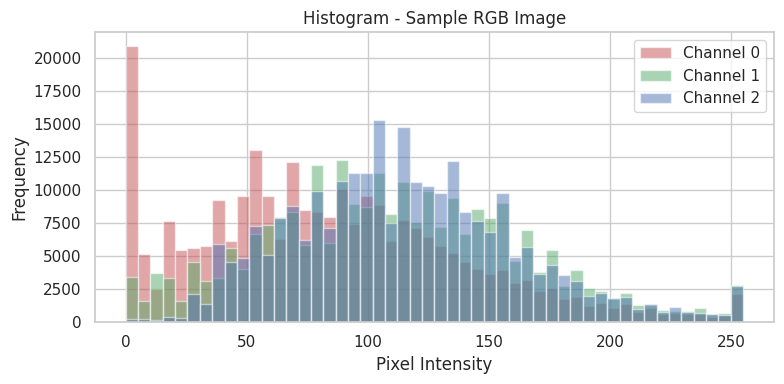

In [18]:
def plot_channel_histogram(image, title="Image"):
    colors = ['r', 'g', 'b']
    plt.figure(figsize=(8, 4))
    for i in range(3):
        plt.hist(image[:, :, i].flatten(), bins=50, color=colors[i], alpha=0.5, label=f'Channel {i}')
    plt.title(f"Histogram - {title}")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()

sample_img = load_tif(train_img_files[0])
plot_channel_histogram(sample_img, title="Sample RGB Image")

## 3. RGB Composite & Mask Visualization
We’ll show:
- The RGB image
- The landslide mask overlayed on top

In [20]:
def normalize_rgb(img):
    img = img.astype(np.float32)
    return (img - img.min()) / (img.max() - img.min())

In [21]:
def visualize_multiple_images_with_masks(img_paths, mask_paths, n=5):
    import matplotlib.pyplot as plt

    # Create subplots: n rows, 2 columns
    fig, axes = plt.subplots(n, 2, figsize=(12, 4 * n))  # Increase height per row

    for i in range(n):
        img = load_tif(img_paths[i])
        mask = load_tif(mask_paths[i])
        if mask.ndim == 3:
            mask = mask[:, :, 0]
        rgb = normalize_rgb(img)

        # Show RGB image
        ax_img = axes[i, 0]
        ax_img.imshow(rgb)
        ax_img.set_title(f"Image {i+1}")
        ax_img.axis("off")

        # Show RGB + Mask overlay
        ax_mask = axes[i, 1]
        ax_mask.imshow(rgb)
        ax_mask.imshow(mask, cmap='Reds', alpha=0.4)
        ax_mask.set_title(f"Image with Landslide Mask {i+1}")
        ax_mask.axis("off")

    plt.subplots_adjust(wspace=0.05, hspace=0.15)  # Reduce horizontal gap between columns
    plt.tight_layout()
    plt.show()


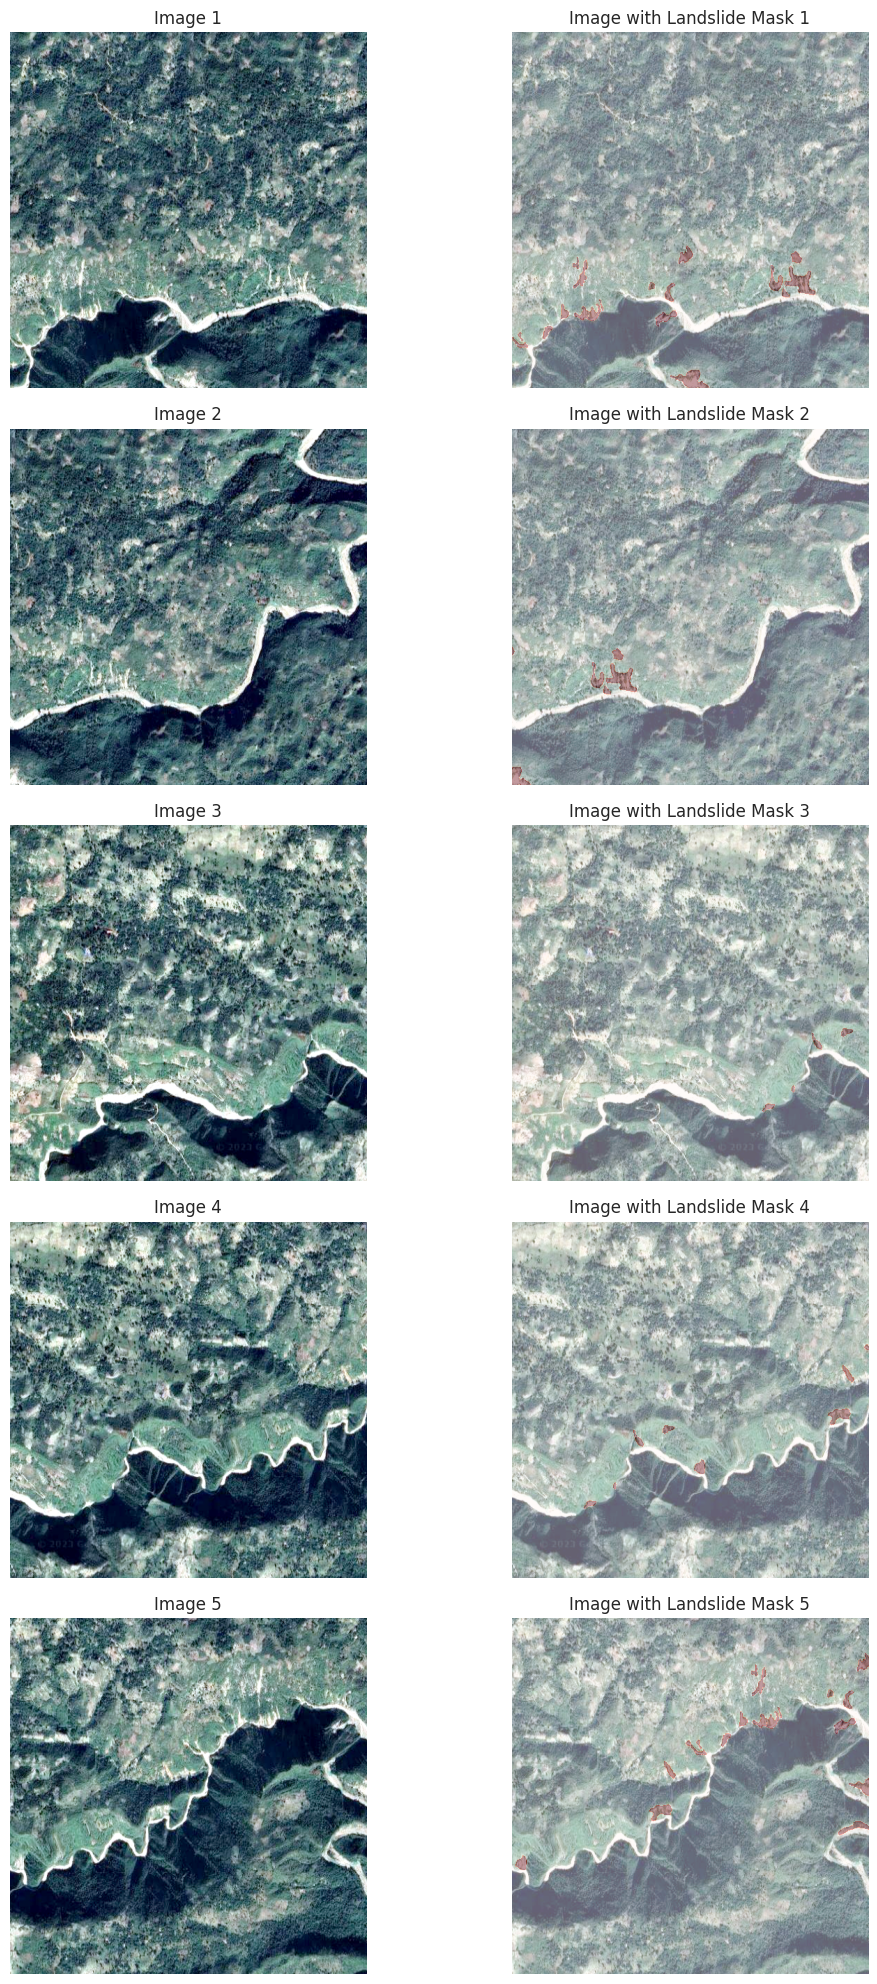

In [22]:
visualize_multiple_images_with_masks(train_img_files, train_mask_files, n=5)